In [ ]:
# time breakdown:
# - 15 minutes research 
# - 1h coding  
# ... training 1h ...
# - 15 min plot of the results + check some examples
# - 15 min cleaning

# hypothesis:
# - similar problem as mnist but with 45 classes 
# - convolutional networks work good for classical mnist to capture digit features so it should work quite good with
# overlapped digits. 

In [1]:
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import random
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn as nn
from torchsummary import summary

## Data Preparation

In [39]:
data = np.load("/Users/juhache/Pro/Inai/inai/data/mnist_2digits_10K.npy")
# crop the images to fit the network (to be improved)
data = [np.array(d[2:30,2:30]) for d in data]
labels_raw = np.load("/Users/juhache/Pro/Inai/inai/data/mnist_2digits_10K_labels.npy")
labels_raw = [int(str(min(l)) + str(max(l))) for l in labels_raw]
labels_values = list(set(labels_raw))
labels_idx = [labels_values.index(l) for l in labels_raw]
max(labels_idx), min(labels_idx),len(labels_values)

(44, 0, 45)

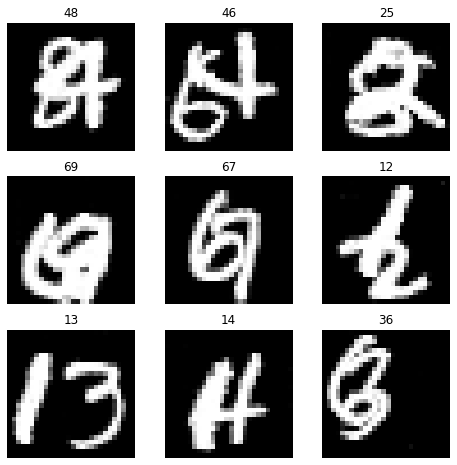

In [44]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img = data[sample_idx]
    label = labels_values[labels_idx[sample_idx]]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Load in Pytorch objects

In [45]:
tensor_x = torch.Tensor(data) # transform to torch tensor
tensor_y = torch.Tensor(np.array(labels_idx))

dataset = torch.utils.data.TensorDataset(tensor_x, tensor_y)

training_data, test_data = torch.utils.data.random_split(dataset, [9000,1000])
train_dataloader =  torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [47]:
from sklearn.model_selection import train_test_split

class MNISTdatasets(torch.utils.data.Dataset):
    def __init__(self, data, label, transform = None):
        self.transform = transform
        self.data = data
        self.label = label
        self.datanum = len(data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.label[idx]

        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label

x_train, x_test, y_train, y_test = train_test_split(data, labels_idx)
transform = ToTensor()

train_dataset = MNISTdatasets(x_train, y_train, transform)
test_dataset = MNISTdatasets(x_test, y_test, transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64,
                                           shuffle=True,
                                          num_workers=0 )
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64, 
                                           shuffle=False,
                                         num_workers=0 )

In [48]:
num_classes = len(labels_values)

#v1
class AlexNet(nn.Module):
    
    def conv_block(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(inplace=True),
        )

    def conv_block_pooling(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
    
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.block1 = self.conv_block(1,96)
        self.block2 = self.conv_block_pooling(96,256)
        self.block3 = self.conv_block(256,384)
        self.block4 = self.conv_block_pooling(384,384)
        self.block5 = self.conv_block(384,256)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256*7*7,1048),
            nn.Dropout(p=0.5),
            nn.Linear(1048,1048),
            nn.Linear(1048,num_classes),
        )

    def forward(self, x):
        x=self.block1(x)
        x=self.block2(x)
        x=self.block3(x)
        x=self.block4(x)
        x=self.block5(x)
        x = x.view(x.size(0),256*7*7)
        x = self.classifier(x)
        return x
    

## Training

In [49]:
net = AlexNet(num_classes).to('cpu')
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(net.parameters())
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [50]:
from tqdm.notebook import tqdm
device = 'cpu'
num_epochs = 20

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    i = 0
    
    net.train() 
    for (images, labels) in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device) 
        optimizer.zero_grad() 
        outputs = net(images.float()) 
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item() 
        loss.backward()
        optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset) 
    avg_train_acc = train_acc / len(train_loader.dataset) 
    
    net.eval() 
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images.float())
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
        avg_val_loss = val_loss / len(test_loader.dataset)
        avg_val_acc = val_acc / len(test_loader.dataset)
    
        print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))

        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.0514, val_loss: 0.0568, val_acc: 0.2064


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [2/20], Loss: 0.0378, val_loss: 0.0435, val_acc: 0.3536


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [3/20], Loss: 0.0283, val_loss: 0.0428, val_acc: 0.3636


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [4/20], Loss: 0.0219, val_loss: 0.0232, val_acc: 0.5580


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [5/20], Loss: 0.0180, val_loss: 0.0286, val_acc: 0.5236


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [6/20], Loss: 0.0148, val_loss: 0.0198, val_acc: 0.6296


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [7/20], Loss: 0.0120, val_loss: 0.0215, val_acc: 0.6344


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [8/20], Loss: 0.0101, val_loss: 0.0373, val_acc: 0.4856


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [9/20], Loss: 0.0089, val_loss: 0.0215, val_acc: 0.6364


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [10/20], Loss: 0.0084, val_loss: 0.0161, val_acc: 0.7028


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [11/20], Loss: 0.0066, val_loss: 0.0208, val_acc: 0.6724


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [12/20], Loss: 0.0062, val_loss: 0.0196, val_acc: 0.6672


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [13/20], Loss: 0.0047, val_loss: 0.0196, val_acc: 0.6924


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [14/20], Loss: 0.0046, val_loss: 0.0227, val_acc: 0.6756


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [15/20], Loss: 0.0038, val_loss: 0.0184, val_acc: 0.7104


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [16/20], Loss: 0.0032, val_loss: 0.0184, val_acc: 0.7096


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [17/20], Loss: 0.0032, val_loss: 0.0184, val_acc: 0.7164


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [18/20], Loss: 0.0030, val_loss: 0.0162, val_acc: 0.7400


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [19/20], Loss: 0.0027, val_loss: 0.0234, val_acc: 0.6864


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch [20/20], Loss: 0.0021, val_loss: 0.0201, val_acc: 0.7172


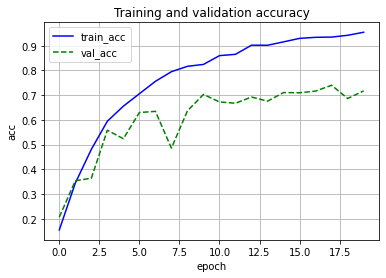

In [109]:
plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

In [60]:
def get_predictions(net, loader, device):
    net.eval()
    images = []
    labels = []
    probs = []
    with torch.no_grad():
        for (x, y) in loader:

            x = x.to(device)

            y_pred= net(x)

            y_prob = torch.nn.functional.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    return images, labels, probs

In [119]:
data_test, labels, probs = get_predictions(net, test_loader, device)
pred_labels = torch.argmax(probs, 1)

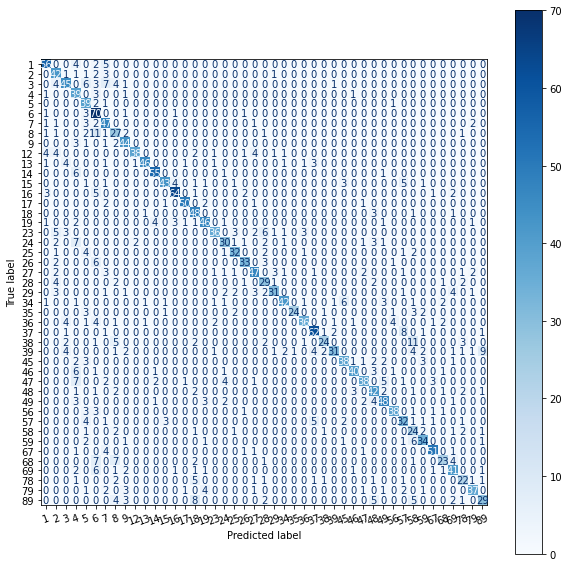

In [120]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
    
plot_confusion_matrix(labels, pred_labels, labels_values) 

## Plot some mistakes

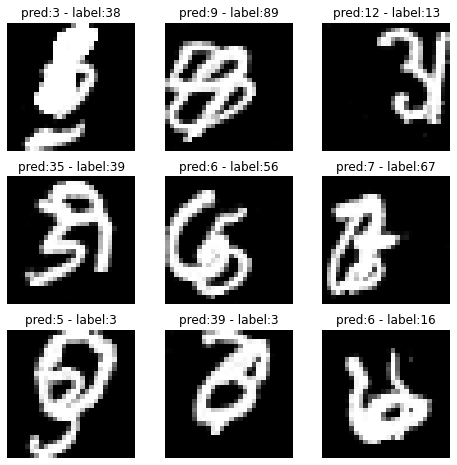

In [121]:
import random
incorrect = [idx for idx,c in enumerate(labels.tolist()) if c != pred_labels.tolist()[idx] ]

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = random.choice(incorrect)
    img = data_test[sample_idx]
    label = labels_values[labels[sample_idx]]
    pred = labels_values[pred_labels[sample_idx]]
    figure.add_subplot(rows, cols, i)
    plt.title(f"pred:{pred} - label:{label}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
# to do:
# - 1: get a baseline with  standart mnist and the 2 first predicted digits.
# - 2: update network to fit 32*32
# - 3: add more images (full mnist dataset), train more epochs, test other params
# - 4: try other network architectures